# Samuel Thelin - samthe-1

## Guiding questions
1. What does teacher forcing mean?

    'Teacher forcing' means to use the ground truth output from the previous iteration/timestep, and use it as input to predict the next timestep (rather than its own predicted output). This is supposed to help the model converge faster and stabilize during training.

2. What is ridge regression? Why is it useful?

    Ridge regression is used to predict continuous values. It includes a penalty term to the loss function - this is what we want, since we want to reduce overfitting. Another factor to why Rdige regression is beneficial is because it "allows a one-shot training with virtually unlimited data". 

3. How to achieve echo state property?

    "The state of the reservoir should be uniquely defined by the fading history of the input". In most situations, when the spectral radius should be less than 1, echo state is achieved.   

4. What is Root-Mean-Square Error (RMSE)?

    RMSE is a way to evaluate the accuracy of regression models. As one can guess based off of the name, it measures the square root of the average differences between predicted and actual values, squares it, and calculates. 

In [36]:
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt

class EchoStateNetwork:
    def __init__(self, input_dim, reservoir_dim, output_dim, spectral_radius=0.8, reg_param=1e-8, input_scaling=1.0):
        """
        Initialize the Echo State Network.
        :param input_dim: Number of input features
        :param reservoir_dim: Number of reservoir neurons
        :param output_dim: Number of output features
        :param spectral_radius: Spectral radius to ensure echo state property
        :param reg_param: Ridge regression regularization parameter
        :param input_scaling: W^{in} scaling (want 0.2 by lab instructions)
        """
        self.input_dim = input_dim
        self.reservoir_dim = reservoir_dim
        self.output_dim = output_dim
        self.spectral_radius = spectral_radius
        self.reg_param = reg_param
        self.input_scaling = input_scaling

        # Initialize random weights for input-to-reservoir and reservoir
        self.W_in = np.random.uniform(-1, 1, (reservoir_dim, input_dim)) * self.input_scaling
        self.W = np.random.uniform(-1, 1, (reservoir_dim, reservoir_dim))

        # Scale the reservoir weight matrix to satisfy echo state property
        max_eigenvalue = max(abs(np.linalg.eigvals(self.W)))
        self.W *= spectral_radius / max_eigenvalue

        # Readout weights (trained later)
        self.W_out = None

    def _update_reservoir(self, x_t, r_prev):
        """
        Update the reservoir state.
        :param x_t: Input at time t
        :param r_prev: Previous reservoir state
        :return: Updated reservoir state
        """
        return np.tanh(np.dot(self.W_in, x_t) + np.dot(self.W, r_prev))

    def fit(self, X, Y):
        """
        Train the ESN using teacher forcing and ridge regression.
        :param X: Input time-series data (shape: [timesteps, input_dim])
        :param Y: Target time-series data (shape: [timesteps, output_dim])
        """
        timesteps = X.shape[0]
        reservoir_states = np.zeros((timesteps, self.reservoir_dim))
        r_prev = np.zeros(self.reservoir_dim)

        # Collect reservoir states using teacher forcing
        for t in range(timesteps):
            if t == 0:
                r_prev = self._update_reservoir(X[t], r_prev)  # Use input for first step
            else:
                r_prev = self._update_reservoir(Y[t-1], r_prev)  # Use ground truth
            reservoir_states[t] = r_prev

        # Discard the first 1,000 steps
        reservoir_states = reservoir_states[1000:]
        Y = Y[1000:]

        # Add bias term to reservoir states
        extended_states = np.hstack([reservoir_states, np.ones((reservoir_states.shape[0], 1))])

        # Solve ridge regression for W_out
        self.W_out = np.linalg.solve(
            np.dot(extended_states.T, extended_states) + self.reg_param * np.eye(extended_states.shape[1]),
            np.dot(extended_states.T, Y)
        )


    def predict(self, X):
        """
        Predict using the trained ESN.
        :param X: Input time-series data (shape: [timesteps, input_dim])
        :return: Predicted time-series (shape: [timesteps, output_dim])
        """
        timesteps = X.shape[0]
        r_prev = np.zeros(self.reservoir_dim)
        predictions = []

        for t in range(timesteps):
            r_prev = self._update_reservoir(X[t], r_prev)
            # Add bias term
            extended_state = np.hstack([r_prev, 1])
            y_t = np.dot(self.W_out.T, extended_state)
            predictions.append(y_t)

        return np.array(predictions)
    
    def predict_autonomous(self, initial_input, timesteps, last_reservoir_state):
        """
        Generate predictions autonomously by feeding outputs back as inputs.
        :param initial_input: Initial input to kickstart the ESN (shape: [input_dim])
        :param timesteps: Number of timesteps to predict
        :param last_reservoir_state: Reservoir state from the end of training
        :return: Predicted time-series (shape: [timesteps, output_dim])
        """
        r_prev = last_reservoir_state
        predictions = []
        input_t = initial_input

        for t in range(timesteps):
            # Update reservoir state using the current input
            r_prev = self._update_reservoir(input_t, r_prev)
            
            # Add bias term and compute output
            extended_state = np.hstack([r_prev, 1])
            y_t = np.dot(self.W_out.T, extended_state)
            predictions.append(y_t)
            
            # Use the output as the next input
            input_t = y_t

        return np.array(predictions)


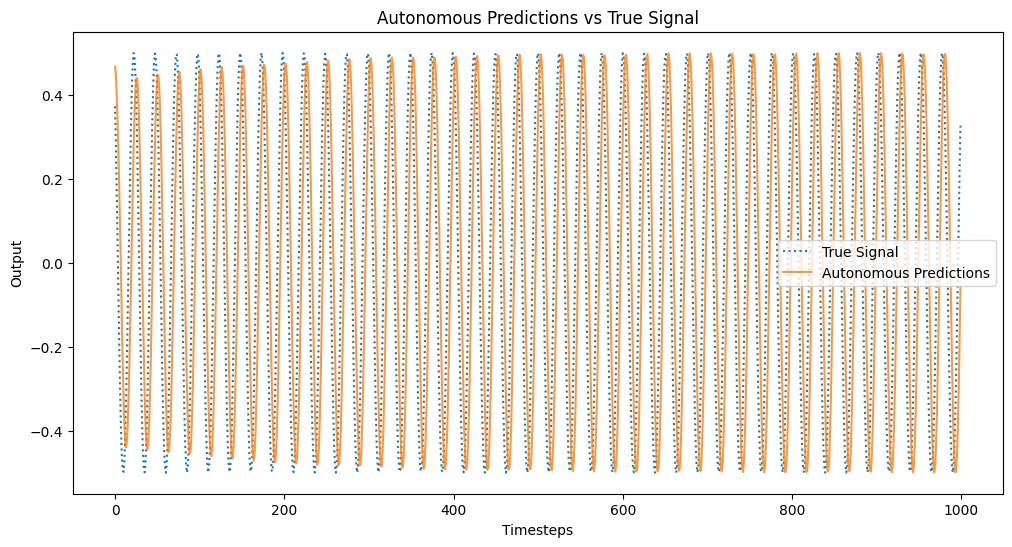

In [37]:
# Define the sinusoidal signal
timesteps = 4000
train_size = 3000
test_size = timesteps - train_size

# Generate the dataset
n = np.arange(timesteps)
X = (np.sin(n / 4)).reshape(-1, 1)  # Input: sin(n/4)
Y = (0.5 * np.sin(n / 4)).reshape(-1, 1)  # Target: 0.5sin(n/4)

# Split into training and testing sets
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]
# Autonomous mode: Generate future predictions
initial_input = X_test[0]  # Use the first test input as the starting point
timesteps_to_generate = 1000  # Generate predictions for the full test set length
reservoir_dim = 1000
esn = EchoStateNetwork(input_dim=1, reservoir_dim=reservoir_dim, output_dim=1, input_scaling=0.2)
# Train the ESN
esn.fit(X_train, Y_train)

# Use the last reservoir state from training
last_reservoir_state = esn._update_reservoir(Y_train[-1], np.zeros(reservoir_dim))

# Autonomous predictions
initial_input = Y_train[-1]  # Last ground truth value from training
Y_autonomous = esn.predict_autonomous(initial_input, 1000, last_reservoir_state)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label="True Signal", linestyle="dotted")
plt.plot(Y_autonomous, label="Autonomous Predictions", alpha=0.8)
plt.title("Autonomous Predictions vs True Signal")
plt.xlabel("Timesteps")
plt.ylabel("Output")
plt.legend()
plt.show()



Experiment 1/10
RMSE for Experiment 1: 0.300433
Experiment 2/10
RMSE for Experiment 2: 0.272758
Experiment 3/10
RMSE for Experiment 3: 0.280886
Experiment 4/10
RMSE for Experiment 4: 0.296073
Experiment 5/10
RMSE for Experiment 5: 0.290031
Experiment 6/10
RMSE for Experiment 6: 0.319698
Experiment 7/10
RMSE for Experiment 7: 0.295459
Experiment 8/10
RMSE for Experiment 8: 0.284867
Experiment 9/10
RMSE for Experiment 9: 0.309618
Experiment 10/10
RMSE for Experiment 10: 0.287548

Mean RMSE Across All Predictions: 0.293678


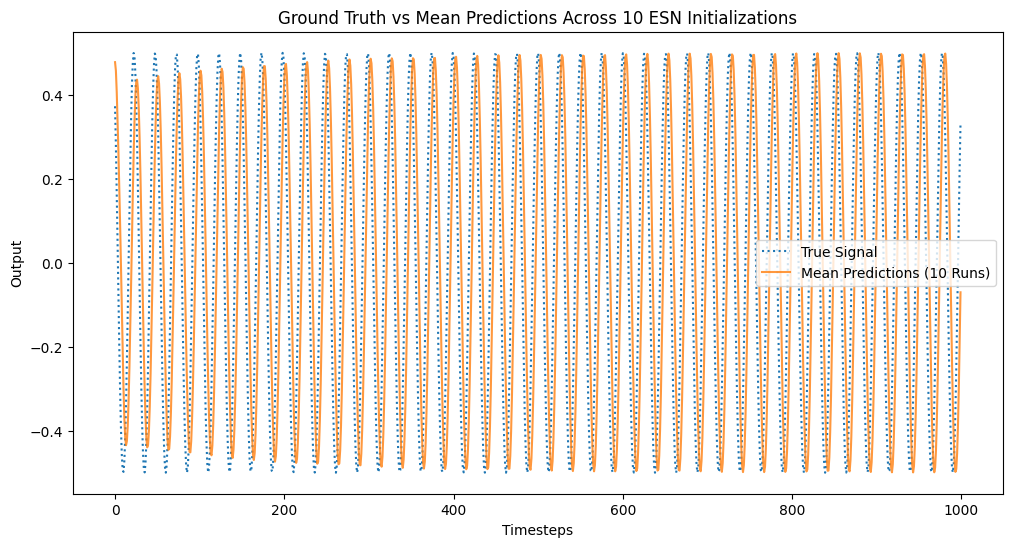

In [38]:
from sklearn.metrics import mean_squared_error

# Repeat the experiment for 10 different initializations
num_experiments = 10
predictions_list = []
rmse_values = []

for i in range(num_experiments):
    print(f"Experiment {i + 1}/{num_experiments}")
    
    # Initialize and train a new ESN
    esn = EchoStateNetwork(input_dim=1, reservoir_dim=1000, output_dim=1, 
                           spectral_radius=0.8, input_scaling=0.2)
    esn.fit(X_train, Y_train)
    
    # Get the last reservoir state from training
    last_reservoir_state = esn._update_reservoir(Y_train[-1], np.zeros(1000))
    
    # Generate autonomous predictions
    initial_input = Y_train[-1]  # Last ground truth value from training
    Y_autonomous = esn.predict_autonomous(initial_input, 1000, last_reservoir_state)
    
    # Store predictions
    predictions_list.append(Y_autonomous)
    
    # Calculate RMSE for this experiment
    rmse = np.sqrt(mean_squared_error(Y_test, Y_autonomous))
    rmse_values.append(rmse)
    print(f"RMSE for Experiment {i + 1}: {rmse:.6f}")

# Compute mean predictions across all experiments
mean_predictions = np.mean(predictions_list, axis=0)

# Compute RMSE for the mean prediction
mean_rmse = np.sqrt(mean_squared_error(Y_test, mean_predictions))
print(f"\nMean RMSE Across All Predictions: {mean_rmse:.6f}")

# Plot ground truth vs mean predictions
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label="True Signal", linestyle="dotted")
plt.plot(mean_predictions, label="Mean Predictions (10 Runs)", alpha=0.8)
plt.title("Ground Truth vs Mean Predictions Across 10 ESN Initializations")
plt.xlabel("Timesteps")
plt.ylabel("Output")
plt.legend()
plt.show()
